<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/mercari_Keras_functional_model_with_multiple_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 20th Oct, 2022
# Myfolder: /home/ashok/Documents/mercari_price_challenge
# Ref: https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl
# VM: lubuntu_deeplearning_II
#
#     Objectives:
#                1. Learning functional model of keras
#                2. Functional model with multiple inputs
#                3. Applying deeplearning to structured tables
#                4. Vector conversion of categorical variables
#                   as also descriptive text


## [Problem](https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview)

It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, one of these sweaters cost $335 and the other cost $9.99. Can you guess which one’s which?

Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

Note that, because of the public nature of this data, this competition is a “Kernels Only” competition. In the second stage of the challenge, files will only be available through Kernels and you will not be able to modify your approach in response to new data. Read more details in the data tab and Kernels FAQ page. 


## Call libraries

In [57]:
# 1.0 Call libraries
# 1.1 Data manipulation libraries
import numpy as np
import pandas as pd

# 1.2 sklearn libraries
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# 1.3 For plotting NN model
#  conda install -c anaconda graphviz
#  conda install -c anaconda pydot
from skimage import io
import pydot

# 1.4 Keras model components
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# 1.4.1 For text (word) to integer transformation
from tensorflow.keras.preprocessing.text import Tokenizer

# 1.4.2 For making all integer sequences of equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1.4.3 Import backend to invoke tensorflow commands to manipulate tensors
from tensorflow.keras import backend as K

# 1.5 Plotting libraries
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline 

# 1.6 Misc
import math, time, os,gc

In [58]:
# 1.7 Check tensorflow version:

tf.__version__    # 2.9.2

'2.9.2'

In [59]:
# 1.8 Print all outputs from a cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## RMSLE 
Root mean squared Logaritmic error is defined, as below. Here, $p_{i}$ is predicted value AND not probability.  See [here](https://hrngok.github.io/posts/metrics/#Root-Mean-Squared-Logaritmic-Error-(RMSLE)) and also [this article](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a).

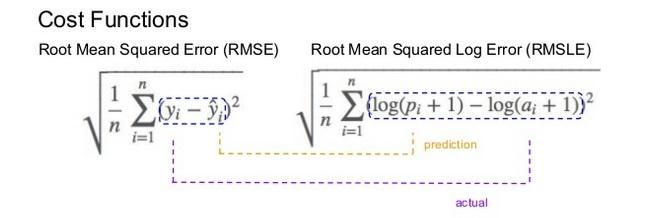

Mechanism:  
It is the Root Mean Squared Error of the log-transformed predicted and log-transformed actual values. RMSLE adds 1 to both actual and predicted values before taking the natural logarithm to avoid taking the natural log of possible 0 (zero) values. As a result, the function can be used if actual or predicted have zero-valued elements. But this function is not appropriate if either is negative valued.


Functionality:
The expression: `log(pi+1)−log(ai+1)`
can be written as `log((pi+1)/(ai+1))` <br>
RMSLE measures the log of ratio of predicted and actual target values. 
(Note: )

#### RMSLE is preferable when
> Targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc <br>
> We care about percentage errors rather than the absolute value of errors. <br>
> There is a wide range in the target variables and we don’t want to penalize big differences when both the predicted and the actual are big numbers. <br>
> We want to penalize under estimates more than over estimates. That is donot sell at lower cost. But overestimate is OK.

For example for P = 1000 and A = 500 would give you the roughly same error as when P = 100000 and A = 50000.



In [60]:
# 1.8 Underestimate by 400
#     More penalized:

p = 600
a = 1000
(math.log(p) - math.log(a))**2


0.2609428178959133

In [61]:
# 1.9 Overestimate by 400

p =  1400
a = 1000
(math.log(p) - math.log(a))**2


0.11321356601688151

### Define rmsle()

In [62]:
# 2. Write a function to calculate Root Mean Squared Logarithmic Error (RMSLE)
#    'y' and 'y_pred' are arrays of actual vs predicted values.
#    Why use RMSLE?
#    Ref: https://stats.stackexchange.com/a/110610

def rmsle(y, y_pred):
    # 2.1 Check if lengths are both arrays are same
    assert len(y) == len(y_pred) 
    # 2.2 Get a list of squared differences of logs
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    # 2.3 Sum up all squared differences, take a mean and then square root 
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
    
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [63]:
# 2. Write a function to calculate Root Mean Squared Logarithmic Error (RMSLE)
#    'y' and 'y_pred' are arrays of actual vs predicted values.
#    Why use RMSLE?
#    Ref: https://stats.stackexchange.com/a/110610

def rmsle(y, y_pred):
    # 2.1 Check if lengths are both arrays are same
    assert len(y) == len(y_pred) 
    # 2.2 Get a list of squared differences of logs:
    t = np.sum(
               (
                   np.sqrt(
                            (np.log(y_pred+1) - np.log(y+1))**2
                           )
                )
               ) / len(y)
    return t
  

## Mount gdrive
And also set path to data

In [64]:
# 2.4
from google.colab import drive
drive.mount('/gdrive')  

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [65]:
# 2.5 Set path to train and test data
path = "/gdrive/MyDrive/Colab_data_files/mercari/"

## Read data
Read both train/test data.<br>
Just plain reading

In [88]:
# 3.1 Read datasets
%%time

print("---Loading data---")

train = pd.read_table(path+"train.tsv.zip")
test = pd.read_table(path+"test.tsv.zip")

print("---finished reading---")

---Loading data---
---finished reading---
CPU times: user 12.5 s, sys: 913 ms, total: 13.4 s
Wall time: 13.5 s


In [89]:
# 3.2
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [90]:
# 3.3 Print some information about datasets
#     In this data target is 'price':

print("---")
print(f"train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("---\n")

# 3.3.1
print(f"train Memory Usage : {sum(train.memory_usage())/10**6} MB")   # In MB
print(f"test Memory Usage : {sum(test.memory_usage())/10**6} MB")    # In MB
print("-----\n")

# 3.3.2 Missing values
print(f"Train Null columns: {train.isnull().sum().sort_values()}")
print(f"Test Null columns: {train.isnull().sum().sort_values()}" )

---
train shape: (1482535, 8)
Test shape: (693359, 7)
---

train Memory Usage : 94.882368 MB
test Memory Usage : 38.828232 MB
-----

Train Null columns: train_id                  0
name                      0
item_condition_id         0
price                     0
shipping                  0
item_description          4
category_name          6327
brand_name           632682
dtype: int64
Test Null columns: train_id                  0
name                      0
item_condition_id         0
price                     0
shipping                  0
item_description          4
category_name          6327
brand_name           632682
dtype: int64


In [91]:
# 3.4 All columns but 'price' and shipping are categorical
train.dtypes
#test.dtypes
train.columns.values

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

array(['train_id', 'name', 'item_condition_id', 'category_name',
       'brand_name', 'price', 'shipping', 'item_description'],
      dtype=object)

## Data pre-processing
>1. Missing values (three)<br>
>2. Label Encoding of categorical columns (three)<br>
>3. Transform fields having descriptive text to int sequences (two)<br>
>4. In each text field, find the length of int sequence with max  length<br>
>5. Scale numeric fields (two)<br>
>6. Create one random numeric field<br>

### Missing values
Fill missing values in categorical columns with constants


In [92]:
# 4.0 Fill missing values
#     Define a function to fill missing values
#     We use pandas methods df.fillna()
#     Fields: category_name, brand_name, item_description

def fill_missing(dataset):
    dataset["category_name"].fillna(value="missing", inplace=True)
    dataset["brand_name"].fillna(value="missing", inplace=True)
    dataset["item_description"].fillna(value="missing", inplace=True)
    return (dataset)

In [93]:
# 4.1 Fill all missing values now in train and test:

train = fill_missing(train)
test = fill_missing(test)

In [94]:
# 4.2 Check if any value is still missing:

train.isnull().sum()
test.isnull().sum()

# 4.3 Look at datasets now
train.head(3)
test.head(3)

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
dtype: int64

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...


### Label Encoding of categorical data
Label encode `category_name` and `brand_name` fields.<br> We will first horizontally merge `category_name` values and `brand_name` values both in train and test.

In [95]:
# 4.4 Label Encode categorical values
#     Two columns: category_name and brand_name

# 4.4.1 Look at train/test category_name data. Each is 1D array:
train["category_name"].values.shape        # 1D (1482535,)
test.category_name.values.shape         # 1D (693359,)

(1482535,)

(693359,)

In [96]:
# 4.4.2 Merge 1D category_name data of train & test into one array:

catname_array = np.hstack([train.category_name.values, test.category_name.values])


# 4.4.3 Also merge brand_name data into one dimensional array

brname_array = np.hstack([train.brand_name.values, test.brand_name.values])

In [97]:
# 4.4.4 So final shapes:
catname_array.shape        # 1D array, (2175894,)
brname_array.shape         # 1D array, (2175894,)

# 4.4.5 And some values
catname_array[:3]
brname_array[:3]

(2175894,)

(2175894,)

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse'], dtype=object)

array(['missing', 'Razer', 'Target'], dtype=object)

In [103]:
# 5.0 Label or integer encode each category and brand name

# 5.1 Instantiate object for category name transformation:

le = LabelEncoder()

# 5.2 Training first on all values:

le.fit(catname_array)

# 5.3 Next transformation of individual sets:

train.category_name = le.transform(train.category_name.values)
test.category_name = le.transform(test.category_name.values)

# 5.4 How many classes:
le.classes_

# 5.5 Length:
print("\n======\n")
MAX_CATEGORY_VOC = len(le.classes_)
print("\n======\n")
MAX_CATEGORY_VOC

LabelEncoder()

array(['Beauty/Bath & Body/Bath',
       'Beauty/Bath & Body/Bathing Accessories',
       'Beauty/Bath & Body/Cleansers', ...,
       "Women/Women's Handbags/Shoulder Bag",
       "Women/Women's Handbags/Totes & Shoppers", 'missing'], dtype=object)

1311

In [104]:
# 5.4 Instantiate another object for brand name transformation:

le = LabelEncoder()

# 5.5 fit and transform
le.fit(brname_array)
train.brand_name = le.transform(train.brand_name.values)
test.brand_name = le.transform(test.brand_name.values)
MAX_BRAND_VOC = len(le.classes_)
print("\n======\n")
MAX_BRAND_VOC

LabelEncoder()

In [22]:
# 5.6 How label encoder works:
#     Transforms alphabetically not by frequency
#     Coding starts from 0:

a = ['zx', 'zx', 'az', 'bb', 'bb', 'bb']
le1 = LabelEncoder()
print(le1.fit_transform(a))

# 5.6.1:

b = ['zx', 'zx','zx','zx', 'az', 'bb', 'bb', 'bb']
le2 = LabelEncoder()
print(le2.fit_transform(b))


[2 2 0 1 1 1]
[2 2 2 2 0 1 1 1]


In [23]:
# 5.7 Delete objects not needed:

print(np.max(catname_array),np.max(brname_array))
del le, catname_array, brname_array
gc.collect()

missing wallis


122

In [106]:
# 5.8 Finally look at transformed data:

train.head(3)
test.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,1000,1094,1,Brand new coach bag. Bought for [rm] at a Coac...


### Transform text fields to integer sequences
Takes time<br>
Fields are `item_description` and `name`. <br>
By default, `Tokenizer()` removes all punctuation, turning the texts into space-separated sequences of words (words maybe include the ' character). These sequences are then split into lists of tokens. They are then indexed.


In [107]:
# 6. Vectorize into integers text data
#    Two columns: item_description, name

# 6.1 We assume that words in 'item_description' and 'name'
#     columns are same or iterchangeable. This assumption
#     is made for simplification. Thst is, T-shirt, if
#     coded as 57 in item_decription' will also be coded 
#     as 57 in 'name' field.
#     (Correct approach would have been to treat the two fields separately)

# 6.2 Stack two columns, item_Description and name, as arrays, end-to-end in 1D array
#     We could also have stacked here: test.item_description.values, test.name.values

raw_text = np.hstack(
                     [
                       train.item_description.values,
                       train.name.values,
                       test.item_description.values,
                       test.name.values
                      ]
                     )

# 6.2.1
raw_text[:3]

array(['No description yet',
       'This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.',
       'Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!'],
      dtype=object)

In [108]:
# 6.3 Train tokenizer
#     https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
#     Tokenizer filters out punctuation, tabs and line-breaks
#
%%time

tok_raw = Tokenizer()           # Create Tokenizer() object
tok_raw.fit_on_texts(raw_text)  # Just training. No transformation as yet


CPU times: user 1min 44s, sys: 471 ms, total: 1min 44s
Wall time: 1min 45s


In [ ]:
# 6.3 Look at word_index

tok_raw.word_index

In [110]:
# And vocab size:

MAX_TEXT_VOC = len(tok_raw.word_index)
MAX_TEXT_VOC   # 321999, say: 322000

321999

In [111]:
# 7. Transform 'item_description' to integer sequences
#    Our trained object tok_raw uses texts_to_sequences()
#    for the purpose:

# 7.1 Takes time
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.values)

# 7.2 Takes time

test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.values)


In [112]:
# 7.3 Check transformed data:

train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098..."
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298..."


In [113]:
# 8.0 Similarly transform 'name' to integer sequences

# 8.1 Takes time:
train["seq_name"] = tok_raw.texts_to_sequences(train.name.values)

# 8.2 Takes time:
test["seq_name"] = tok_raw.texts_to_sequences(test.name.values)


In [114]:
# 8.3 Look at data again:

train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3878, 8988, 6978, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098...","[11404, 27915, 17355, 2667]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298...","[7812, 10862, 666]"


### Max vocabulary sizes of all cat columns

In [115]:
# 9.4 Column, item_condition, already in integer format
MAX_CONDITION_VOC = np.max([
                            train.item_condition_id.max(),
                            test.item_condition_id.max()
                           ]
                          ) + 1

print(f"Maximum Vocabulary size in item_condition_id is {MAX_CONDITION_VOC} ")

Maximum Vocabulary size in item_condition_id is 6 


In [116]:
# 9.2.1
MAX_TEXT_VOC 
MAX_CATEGORY_VOC  # 1311
MAX_BRAND_VOC     # 5290
MAX_CONDITION_VOC

321999

1311

5290

6

#### Histogram to look at distributions
Look at distribution of lengths of integer sequences

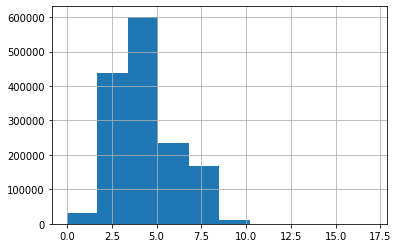

In [117]:
# 11.3 Get histogram of distribution of seq_name lengths
#      Histogram can be used to decide where to cut-off max lengths

train.seq_name.apply(lambda x: len(x)).hist()

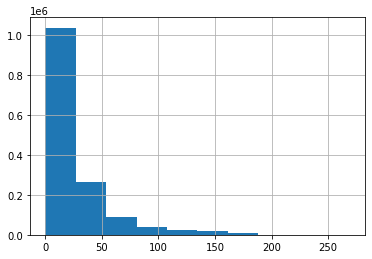

In [118]:
# 11.4 Get histogram of distribution of seq_item_description 
#      Histogram can be used to decide where to cut-off max lengths

train.seq_item_description.apply(lambda x: len(x)).hist()

In [119]:
# 12 EMBEDDINGS MAX VALUES
# 12.1 Based on the histograms, we select the max lengths
#      OR timesteps in RNN for two integer sequences, as:
#      Implication: Longer integer sequences will be truncated

MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75

## Numeric fields
Scale numeric field and create a random numeric field

### Scale 'price' field
>Take a log of 'price' to make it symmetrical  
>Scale the logged values using minmax scaler  
>Scaled price field is called 'target'

In [121]:
# 13 Scale target variable, 'price': 
#     First take log and then scale log

# 13.1 First take a log of target. Why?
#      Make target values symmetric:

train["target"] = np.log( train.price + 1)   # Add 1 to escape from -ve infinity


In [122]:
# 13.2 Then scale log values using min-max scaler between -1 and 1
#      Why?
#      Scaling between (-1,1) is helpful in NN modeling

target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7d3652490>]],
      dtype=object)

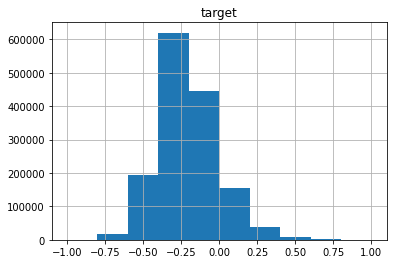

In [123]:
# 13.3 Display histogram of transformed target
#      It is quite symmetric

pd.DataFrame(train.target).hist()

### Create one more num column
This column will have random number values. The only numeric feature that we have is `'shipping'`. We will create one more  numerical column with random values for better demonstration of our proposed architecture. Otherwise, this column is NOT at all needed.


In [124]:
# 13.4 Create an arbitrary column. Why?
#      We want two numerical columns for better demonstration of our
#      proposed architecture. Otherwise, this column is NOT at all needed

# 13.5 Add some small random values to shipping column and create a new column

train['ship_rand'] = train.shipping + np.random.random(size = train.shipping[0])
train.head(3)

# 13.6
test['ship_rand'] = test.shipping + np.random.random(size = test.shipping[0])
#test.head(3)

# 13.7
train.shape    # (1482535, 12)
test.shape     # (693359, 10)   Missing 'price' and its transformed column 'target'


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name,target,ship_rand
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3878, 8988, 6978, 208, 84, 6, 155]",-0.369464,1.613417
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098...","[11404, 27915, 17355, 2667]",0.044005,0.613417
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298...","[7812, 10862, 666]",-0.369464,1.613417


(1482535, 12)

(693359, 10)

## Modeling--initial steps
>Split data<br>
>Expt with pad_sequences()<br>
>Define a function to create a dictionary of data

### Split data

In [125]:
# 18. Split into train and test
#     Note that we do not have 'y' here. 
#     Why? Because 'price' is a continuous variable

# 18.1 Just 'train' will be split into two parts
#      This is permissible in sklearn syntax

dtrain, dvalid = train_test_split(train,
                                  random_state=123,
                                  train_size=0.99    # 99% vs 1%
                                 )

print(dtrain.shape)     # (1467709, 12)
print(dvalid.shape)     # (14826, 12) 1% of above

(1467709, 12)
(14826, 12)


### Experiment with pad_sequences
Our dataset has:<br>
> 1. Categorical columns
>> Three integer columns: <b>item_condition_id</b>, <b>category_name</b> and <b>brand_name</b><br>
>> Two columns (of integer sequences): <b>seq_item_description</b> and <b>seq_name</b><br>

> 2. Numeric columns (two): <b>shipping, ship_rand</b><br>
> 3. Target column 'target'<br>

Thus total number of columns are: 3 +2 + 2+ 1 = 8


In [126]:
# 18.1.1 Just have a look at the train data:
dtrain.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name,target,ship_rand
407853,407853,maroon velvet lisette shorts,1,1162,737,22.0,1,brand new from brandy melville,"[16, 5, 43, 537, 586]","[825, 1027, 17236, 129]",-0.175509,1.613417
748699,748699,Benefit Roller Lash Mascara FULL SIZE,2,26,574,14.0,1,Benefit Roller Lash Mascara FULL SIZE in the c...,"[1238, 2566, 1266, 641, 153, 6, 7, 2, 48, 24, ...","[1238, 2566, 1266, 641, 153, 6]",-0.287907,1.613417
320295,320295,Holographic Ipsy Bag,2,1303,5265,7.0,0,Used once,"[31, 96]","[2896, 2224, 101]",-0.453202,0.613417


Integer sequence columns `seq_item_description` and `seq_name` must have sequences of equal length. So we pad-sequences in each column. Here is what padding does.

In [127]:
# 18.2 Using keras pad_sequences function:
#      Example

print(f" Max size of sequence: {MAX_NAME_SEQ}")
print(f" Shape of dtrain.seq_name: {dtrain.seq_name.shape}")

s = pad_sequences(
                   dtrain.seq_name,
                   maxlen=MAX_NAME_SEQ
                  )

 Max size of sequence: 10
 Shape of dtrain.seq_name: (1467709,)


In [128]:
# 18.3 As 's' will be a numpy array
#       to observe it let us transform it
#        into pandas dataframe:

print(f"Shape of s: {s.shape}")

# 18.4 Here is dataframe:
pd.DataFrame(s).head(3)

Shape of s: (1467709, 10)


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,825,1027,17236,129
1,0,0,0,0,1238,2566,1266,641,153,6
2,0,0,0,0,0,0,0,2896,2224,101


### Define a function to create a dictionary of data
That is we are sort of transforming pandas dataframe to a dictionary as per our conveience


In [129]:
# 19.0 As we want to process, different cols differently,
#      for these columns, we need as many datasets. 
#      WE have SIX columns or column-sets for processing.

#      Define a function that creates datasets in 
#      a dictionary format to help to feed data into keras
#      All columns but the last 'num_vars' are categorical
#      So all columns but the last begin with Embedding layer

def get_keras_data(dataset):
    X = {   
        'name_in':           pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),                        # 1
        'item_desc_in':      pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),       # 2
        'brand_name_in':     np.array(dataset.brand_name),                                                # 3
        'category_name_in':  dataset.category_name.values,                                                # 4
        'item_condition_in': dataset.item_condition_id.values,                                            # 5
        'num_vars_in':       np.array(dataset[["shipping", "ship_rand"]])    # Two numeric columns here   # 6
    }
    return X


In [130]:
# 19.1 Get these datasets now:

X_train = get_keras_data(dtrain)  # type: dict

In [131]:
X_train.keys()

dict_keys(['name_in', 'item_desc_in', 'brand_name_in', 'category_name_in', 'item_condition_in', 'num_vars_in'])

In [132]:
# 19.1.1 Observe X_train:
#        Just print two objects
#        for each data:

for key, value in X_train.items():
    print("\n\n============")
    print(key, ' : ', value[:2])



name_in  :  [[    0     0     0     0     0     0   825  1027 17236   129]
 [    0     0     0     0  1238  2566  1266   641   153     6]]


item_desc_in  :  [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0    16     5
     43   537   586]
 [    0     0     0  1238  2566  1266   641   153     6     7     2    48
     24    13    20   100    16     5    56    50   113   650   379    40
    267     7   160   347    29   641   343     3    21   639     8     2
   2021   469     9    13    20   410    26    74   376   349    22    32
    228    15    36   697    33 17096     8    77  1523   140   138  1244
     

In [133]:
# 19.1.2 Similarly get subsets 
#        for X_valid and X_test:

X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [134]:
# 19.2 As each dict item is a numpy array,
#      we can check shapes. We need these below:

print(X_train["name_in"][:4])
print("\n===========")
print(X_train["name_in"].shape)

[[    0     0     0     0     0     0   825  1027 17236   129]
 [    0     0     0     0  1238  2566  1266   641   153     6]
 [    0     0     0     0     0     0     0  2896  2224   101]
 [    0     0   444   433 12285    95    95  3956   244 11547]]

(1467709, 10)


In [135]:
# 19.3 Check more shapes.

print(X_train["item_desc_in"][:4])
print("\n\n===========")
print(X_train["item_desc_in"].shape)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0    16     5
     43   537   586]
 [    0     0     0  1238  2566  1266   641   153     6     7     2    48
     24    13    20   100    16     5    56    50   113   650   379    40
    267     7   160   347    29   641   343     3    21   639     8     2
   2021   469     9    13    20   410    26    74   376   349    22    32
    228    15    36   697    33 17096     8    77  1523   140   138  1244
     18    51   133    63   385    83   177   261    42   550   175     3
     35   191  1897]
 [    0     0     0     0     0     0     0     0     0     0     0   

In [136]:
# 19.4 Check more shapes. 

X_train["num_vars_in"][:4]
print("\n ----")
X_train["num_vars_in"].shape[1]       # 2

array([[1.        , 1.61341738],
       [1.        , 1.61341738],
       [0.        , 0.61341738],
       [1.        , 1.61341738]])


 ----


2

## About embedding of categorical values in vector-space
Small write up


### A
Consider following sentences:<br><p>
1. mango is sweet<br>
2. apple is sweet<br>
3. mouse moves pointer<br>
4. iphone mobile is used for communication<br>

In a dataset there are multiple text/nominal columns. The nominal values in any column are related with one another. Consider the following table with three categorical columns. For example, mango, apple, grapes and banana in column 'x1' are related to one another through the target, 'x3'. Similarly, items disk, laptop, mouse and mobile in column 'x2' are related to one another through 'x3'.  

We, therefore, need two distinct embedding layers in this dataset.   

An embedding layer will converts word to vector-spaces to discover relationship among words. Or, one can say that conversion of a word to vectors, facilitates finding association between context words. See picture below.


| x1   |   x2    |   x3    |
|------|---------|---------|  
|mango |  disk   |  23  |
|apple |  laptop   |  36  |
|grapes | mouse |  80  |
|banana| mobile  |25|

Conversion of categorical values to word-vectors also helps discover better association between mango and 23 OR apple and 64 than by simply label encoding them and applying machine learning algo to discover patterns.

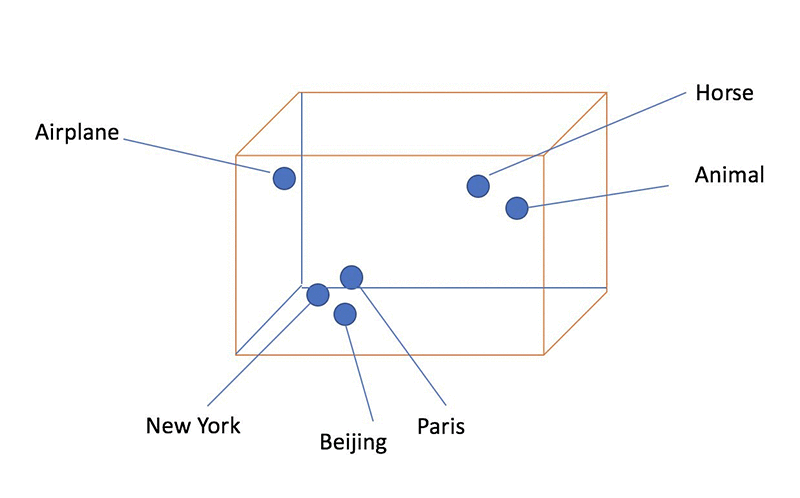

## Model

### Callback functions
Ignore these in first reading

#### Why Early stopping works?
Explore modeling surfaces [here](https://losslandscape.com/explorer). Study optimization techniques [here](https://www.kdnuggets.com/2020/12/optimization-algorithms-neural-networks.html)

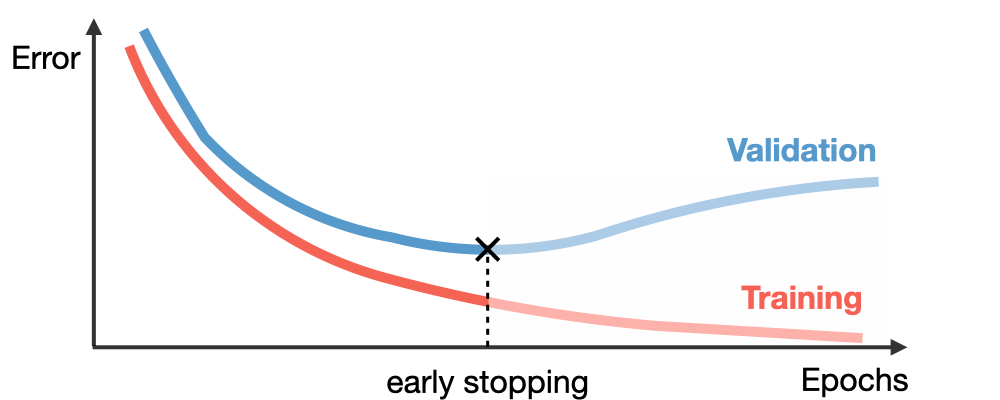

In [137]:
# 20.0 Define callback function for earlystopping and storing weights
#      May forget this in the first reading:

# 20.0.1 Place where checkpoint data will be stored
checkptfilepath = "/content/model"

# 20.0.2 Delete if it exists

! rm -r -f /content/model



In [138]:
# 20.0.3 Define callbacks now:

callbacks = [
    EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),

    ModelCheckpoint( filepath=checkptfilepath, save_best_only=True)
]


In [139]:
# 20.1 Forget it in first reading. Another loss function
#      Any functions used in the model must use tensors
#      and not numpy arrays. Of course, dataset can be numpy:

def rmsle_cust(y_true, y_pred):
    first_log = K.log(
                       K.clip(y_pred,
                              K.epsilon(),
                              None
                              ) + 1.
                      )
    
    second_log = K.log(
                        K.clip(y_true,
                               K.epsilon(),    # Min value
                               None            # max value  
                               ) + 1.
                       )
    out = K.sqrt(
                  K.mean(
                          K.square(
                                    first_log - second_log
                                   ),
                          axis=-1)    # -1 means the last axis
                  )

    return out

### Constants

In [140]:
# 21 Define sizes of categorical values AND word to vectors
#      Sizes?

word2vec_size = 50   # For text columns
cat2vec_size = 10    # For brand_name and category_name 
cond2vec_size = 5    # For item_condition col

### Input tensors
Recall that purpose of Input layer is to output a tensor of appropriate shape for the subsequent layers. Thus `Input()` requires input data-shape and a name (if there are more than one Input).

About Input shapes:<br>
**Input layer: Dense**<br>
Input will be one row at a time. So shape is number of features<br>
**Input layer: Conv2D:**<br>
Input will be Image at a time. So Shape is size of image: width * height * depth. depth is also called 'channels'. <br>
**Input layer: Conv1D:**<br>
Input will be one row at a time. So shape will be: No of features * depth<br>
**Input layer: Embedding layer**<br>
Inputs will be: a) Length of each sequence and, b) Size of vector to which each integer in the sequence is to be transformed to ie word2vec size.<br>  

### Embedding layers and RNN
Diagrammetic Explanations 

Let us see visually an overall picture of how modeling takes place. 

#### For 'brand' and 'category'

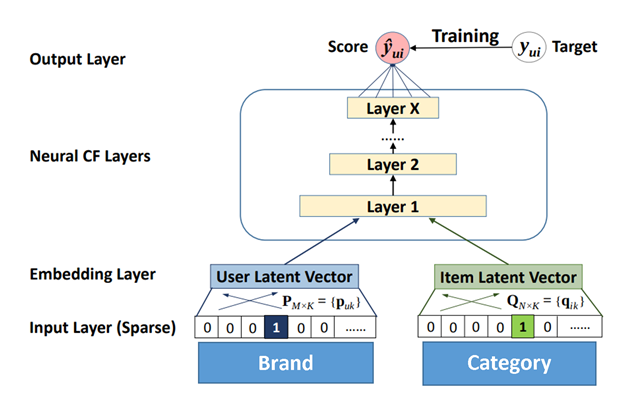

#### For 'name' and 'item-description'

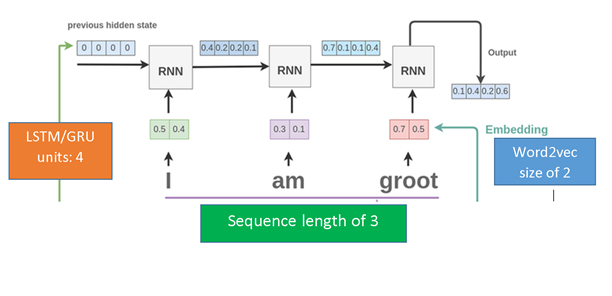

#### More detailed for name and item-description
In each *Embedding layer* specify the <u>vocabulary size</u> and <u>word2vec</u> size. In the following diagram, we assume that our maximum comment/phrase size is 2 ('go home').  And, we are also transforming each word (eg, 'GO') to a vector of size two (0.35, 0.90).  
Phrase size will decide the number of RNNs or LSTMs or GRUs we will have.

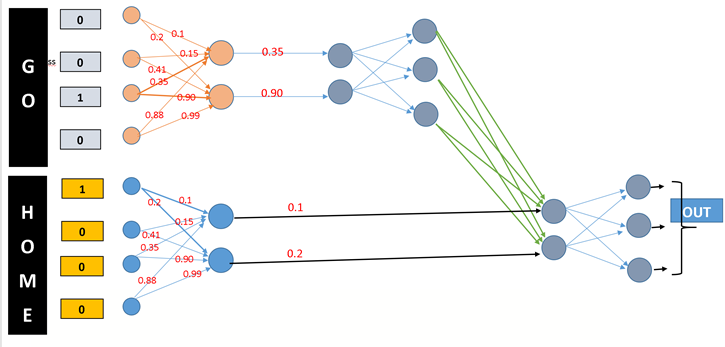

#### LSTM/GRU

While an LSTM or GRU have two outputs, the number of bits or 'units' for both *ct* (ie *state*) and *ht* (ie *output*) are same. Thus, in the syntax for LSTM or GRU only units parameter has to be specified. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) syntax of lstm and [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) syntax of GRU.

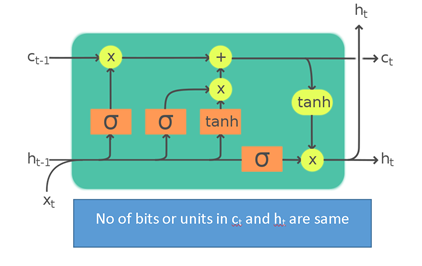

### Input layers definititon

What all numbers do we need, at the minimum?  
Before we proceed further, there should be clarity about these. At the minimum three numbers have to be specified. Seq length, word2vec size and number of output units of RNN/LSTM/GRU.

In [141]:
# 21.1 SIX Inputs. At each input specify number of input-features:

name =            Input(shape=[X_train["name_in"].shape[1]],      name="name_in")           # Length of each sequence
item_desc =       Input(shape=[X_train["item_desc_in"].shape[1]], name="item_desc_in")      # Length of each sequence
brand_name =      Input(shape=[1],                             name="brand_name_in")     # Just 1 feature. Hence shape=[1]
category_name =   Input(shape=[1],                             name="category_name_in")  # Just 1 feature. Hence shape=[1]
item_condition =  Input(shape=[1],                             name="item_condition_in") # Just 1 feature. Hence shape = [1]
num_vars =        Input(shape=[X_train["num_vars_in"].shape[1]],  name="num_vars_in")


In [142]:
# 21.2 FIVE Embeddings layers.  Embedding vectors of first FIVE of the above

# 21.3   Output of following two also go in RNN.
#        RNN output needs no flattening as this output is received
#        AFTER all timesteps have been fed into RNN:

emb_name =           Embedding(MAX_TEXT_VOC,      word2vec_size  )(name)               
emb_item_desc =      Embedding(MAX_TEXT_VOC,      word2vec_size  )(item_desc)

# 21.3.1 Output of following three go directly into Dense layer after flattening
#        These need to be flattened as for every timestep there is a vector
emb_brand_name =     Embedding(MAX_BRAND_VOC,     cat2vec_size  )(brand_name)
emb_category_name =  Embedding(MAX_CATEGORY_VOC,  cat2vec_size  )(category_name)
emb_item_condition = Embedding(MAX_CONDITION_VOC, cond2vec_size )(item_condition)

### RNN layers
The above diagram also explains output of RNN (read GRU).

In [143]:
# 22 TWO RNN layers. Both these are independent of each other:

rnn_layer2 = GRU(8) (emb_name)          # Output of GRU is a vector of size 8
rnn_layer1 = GRU(16) (emb_item_desc)    # Output of GRU is a vector of size 16

### Conv1D layers


We could have fed each or one of the *Embedding layer* outputs to Conv1D. But we will not do so. Left as an exercise for students. Below commented code gives an hint. You will be able to do this only if the incoming layer is large enough so that convolution operation does not reduce it to negative numbers.

In [ ]:
# rnn_layer1 = Reshape([rnn_layer1.shape[1],1])(rnn_layer1)
# rnn_layer1 = Conv1D( filters = 32,kernel_size = 3,activation = 'relu')(rnn_layer1)

### Concatenation

In [144]:
# 23. Before we concatenate, let us see shape of 
#     each output tensor:

print(f"emb_brand_name: {emb_brand_name.shape}")            # (None, 1, 10)
print(f"emb_category_name: {emb_category_name.shape}")      # (None, 1, 10)
print(f"emb_item_condition: {emb_item_condition.shape}")    # (None, 1, 5)
print(f"rnn_layer1: {rnn_layer1.shape}")                    # (None, 16)
print(f"rnn_layer1: {rnn_layer2.shape}")                    # (None, 8)


emb_brand_name: (None, 1, 10)
emb_category_name: (None, 1, 10)
emb_item_condition: (None, 1, 5)
rnn_layer1: (None, 16)
rnn_layer1: (None, 8)


In [145]:
# 23.1 Concatenate all layer-branches:

main_l = concatenate(
                        [
                          Flatten() (emb_brand_name),
                          Flatten() (emb_category_name),
                          Flatten() (emb_item_condition),
                          rnn_layer1,       # Flatten()(rnn_layer1),
                          rnn_layer2,
                          num_vars          # Feed numerical variables as they are
                        ]
                      )

### Classification layer

In [146]:
# 24.0 Level of dropouts: 10%
dr_r = 0.1   

# 24.1 Add classification layer
main_l = Dense(128) (main_l)
main_l = Dropout(dr_r)(main_l)
main_l = Dense(64) (main_l)
main_l = Dropout(dr_r) (main_l)

### Output node

In [147]:
# 24.2 Output neuron
output = Dense(1, activation="linear") (main_l)

## Model as a function

In [148]:
# 24.3 Put all the above under one function:

def create_model():
    # SIX Inputs
    name =            Input(shape=[X_train["name_in"].shape[1]],      name="name_in")           # Length of each sequence
    item_desc =       Input(shape=[X_train["item_desc_in"].shape[1]], name="item_desc_in")      # Length of each sequence
    brand_name =      Input(shape=[1],                             name="brand_name_in")     # Just 1 feature. Hence shape=[1]
    category_name =   Input(shape=[1],                             name="category_name_in")  # Just 1 feature. Hence shape=[1]
    item_condition =  Input(shape=[1],                             name="item_condition_in") # Just 1 feature. Hence shape = [1]
    num_vars =        Input(shape=[X_train["num_vars_in"].shape[1]],  name="num_vars_in")
    # Embedding layer
    emb_name =           Embedding(MAX_TEXT_VOC,      word2vec_size  )(name)               
    emb_item_desc =      Embedding(MAX_TEXT_VOC,      word2vec_size  )(item_desc)
    emb_brand_name =     Embedding(MAX_BRAND_VOC,     cat2vec_size  )(brand_name)
    emb_category_name =  Embedding(MAX_CATEGORY_VOC,  cat2vec_size  )(category_name)
    emb_item_condition = Embedding(MAX_CONDITION_VOC, cond2vec_size )(item_condition)

    # TWO RNN layers. 
    rnn_layer2 = GRU(8) (emb_name)          
    rnn_layer1 = GRU(16) (emb_item_desc)    

    # Concatenate
    main_l = concatenate(
                        [
                          Flatten() (emb_brand_name),
                          Flatten() (emb_category_name),
                          Flatten() (emb_item_condition),
                          rnn_layer1,       # Flatten()(rnn_layer1),
                          rnn_layer2,
                          num_vars          # Feed numerical variables as they are
                        ]
                      )
    
    # Classification 
    dr_r = 0.1   
    main_l = Dense(128) (main_l)
    main_l = Dropout(dr_r)(main_l)
    main_l = Dense(64) (main_l)
    main_l = Dropout(dr_r) (main_l)
    output = Dense(1, activation="linear") (main_l)

    # 25 Formulate Model now
    model = Model(
              inputs= [                     
                        name,
                        item_desc,
                        brand_name,
                        category_name,
                        item_condition,
                        num_vars
                       ],
              outputs= output
              )

    return model
    



### Define model and compile

In [149]:
# 25 Formulate Model now
model = create_model()

In [150]:
# 25.1
model.compile(loss="mse",
              optimizer="adam",
              metrics=["mae"]    # Not using rmsle_cust
              )

### Model summary and plot

In [151]:
# 26 Formulate model and show summary    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name_in (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 category_name_in (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 item_condition_in (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 item_desc_in (InputLayer)      [(None, 75)]         0           []                               
                                                                                              

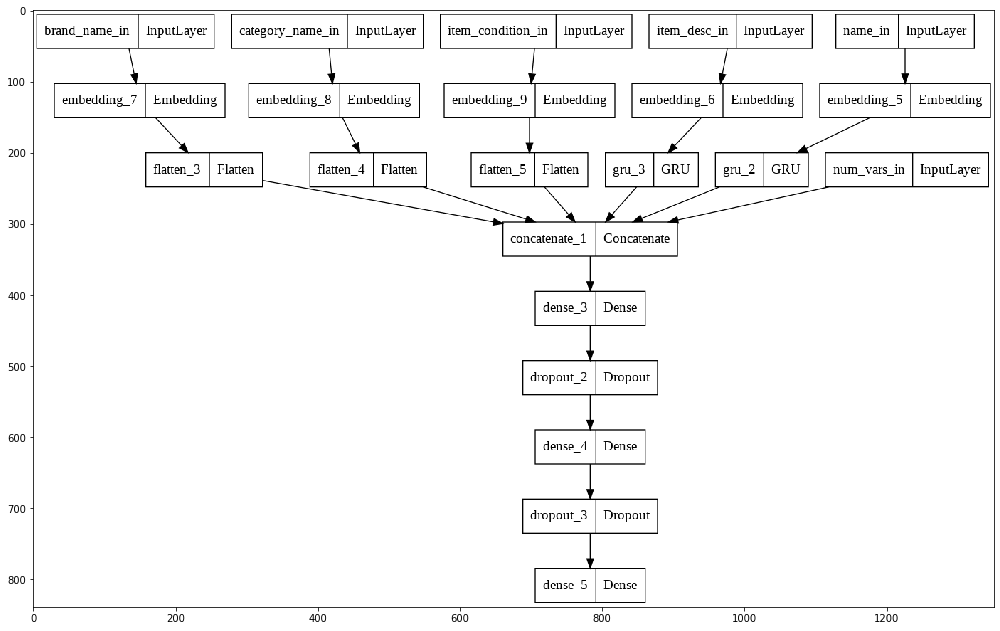

In [152]:
# 26.1 Plot the model architecture
#      We need graphviz and pydot to be installed
plt.figure(figsize = (14,14));
plot_model(model, to_file = "model.png");
io.imshow("model.png");

### Fit model
Takes time

In [154]:
# 26.2. Some constants
BATCH_SIZE = 20000
epochs = 5

In [155]:
# 26.3 Observe our training data once more:
#      Note that X_train is a dictionary of arrays:

for key, value in X_train.items():
    print("\n\n============")
    print(key, ' : ', value[:2])



name_in  :  [[    0     0     0     0     0     0   825  1027 17236   129]
 [    0     0     0     0  1238  2566  1266   641   153     6]]


item_desc_in  :  [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0    16     5
     43   537   586]
 [    0     0     0  1238  2566  1266   641   153     6     7     2    48
     24    13    20   100    16     5    56    50   113   650   379    40
    267     7   160   347    29   641   343     3    21   639     8     2
   2021   469     9    13    20   410    26    74   376   349    22    32
    228    15    36   697    33 17096     8    77  1523   140   138  1244
     

In [156]:
# 26.4

start = time.time()
history= model.fit(X_train,
                   dtrain.target,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
                   validation_data=(X_valid, dvalid.target),
                   callbacks = callbacks,
                   verbose=1
                  )

end = time.time()
print((end-start)/60)    # Five epochs take 15 minutes. Per epoch 240 secs 0.0931

Epoch 1/2
74/74 [==============================] - ETA: 0s - loss: 0.0467 - mae: 0.1622

74/74 [==============================] - 267s 4s/step - loss: 0.0467 - mae: 0.1622 - val_loss: 0.0201 - val_mae: 0.1083
Epoch 2/2
74/74 [==============================] - ETA: 0s - loss: 0.0223 - mae: 0.1139

74/74 [==============================] - 260s 4s/step - loss: 0.0223 - mae: 0.1139 - val_loss: 0.0169 - val_mae: 0.0984
8.78621830145518


In [ ]:
# LINES TO SAVE THE MODEL MISSING

## Load saved model and evaluate
Delete existing model

In [ ]:
# 27.0 Delete earlier model

del model

gc.collect()

In [ ]:
# # 27.1 Create model structure
myModel = create_model()

# 27.2 Loads model weights
myModel.load_weights(checkptfilepath)

In [ ]:
# 27.3 Evaluate model using validation data:

val_preds = myModel.predict(X_valid)

In [ ]:
# 27.4 Undo transformation by MinMaxScaler

val_preds = target_scaler.inverse_transform(val_preds)  

In [ ]:
# 27.5 Undo logs:

val_preds = np.exp(val_preds) - 1   # It should be -1. Original code has +1
print(val_preds[:10])     # (10,1)

print(val_preds[:10, 0])  # Convert to 1D
y_pred = val_preds[:,0]

In [ ]:
# 27.6 Mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_true[:10]

# 27.7
v_rmsle = rmsle(y_true, y_pred)
print("\n RMSLE error on dev test: "+str(v_rmsle))

In [ ]:
########### I am done #############
# Optional

# 20. Create Predictions on test data
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

# 20.1
submission = test[["test_id"]]
submission["price"] = preds

In [ ]:
# 20.2 Should you want to submit on 
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()


This was just an example how nn can solve this problems. Potencial improvements of the kernel:
    - Increase the embeddings factors
    - Decrease the batch size
    - Add Batch Normalization
    - Try LSTM, Bidirectional RNN, stack RNN
    - Try with more dense layers or more rnn outputs
    -  etc. Or even try a new architecture!